# Overview

Compete in the Zillow Kaggle competition to further optimize Zillow's Zestimate.

In this competition, Zillow is asking you to predict the log-error between their Zestimate and the actual sale price, given all the features of a home. The log error is defined as

logerror=log(Zestimate)−log(SalePrice)

and it is recorded in the transactions file train.csv. In this competition, you are going to predict the logerror for the months in Fall 2017. Since all the real estate transactions in the U.S. are publicly available, we will close the competition (no longer accepting submissions) before the evaluation period begins.

**Train/Test split**
* You are provided with a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.
* The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.
* The test data in the public leaderboard has the rest of the transactions between October 15 and December 31, 2016.
* The rest of the test data, which is used for calculating the private leaderboard, is all the properties in October 15, 2017, to December 15, 2017. * This period is called the "sales tracking period", during which we will not be taking any submissions.
* You are asked to predict 6 time points for all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).
* Not all the properties are sold in each time period. If a property was not sold in a certain time period, that particular row will be ignored when calculating your score.
* If a property is sold multiple times within 31 days, we take the first reasonable value as the ground truth. By "reasonable", we mean if the data seems wrong, we will take the transaction that has a value that makes more sense.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data

In [2]:
import warnings
warnings.filterwarnings("ignore")

prop_2016 = pd.read_csv("properties_2016.csv")
train_2016 = pd.read_csv("train_2016_v2.csv")

In [3]:
prop_2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [4]:
train_2016.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [5]:
# merges prop_2016 and train_2016 with matching parcelid
data = pd.merge(train_2016, prop_2016, on='parcelid', how='left')
prop_2016 = None
train_2016 = None

pd.options.display.max_columns = len(data.columns)
pd.options.display.max_rows = len(data)
pd.options.display.max_colwidth = None

In [6]:
data.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,468.0,NaN,NaN,33668120.0,-117677556.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,6.059052e+07,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,598.0,NaN,NaN,33485643.0,-117700234.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059042e+07,17686.0,1286.0,NaN,96961.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


**Feature Descriptions**

Combine feature dictionary with datatype

In [7]:
temp = pd.DataFrame({'Feature': data.dtypes.sort_index().index, 'dtype': data.dtypes.sort_index()})
temp.reset_index(drop=True, inplace=True)
temp = temp.astype({'Feature' : 'string'})
temp.head(5)

,Feature,dtype
0,airconditioningtypeid,float64
1,architecturalstyletypeid,float64
2,assessmentyear,float64
3,basementsqft,float64
4,bathroomcnt,float64


In [8]:
feature_descr = pd.read_excel('zillow_data_dictionary.xlsx')
feature_descr = feature_descr.astype({'Feature' : 'string'})
feature_descr.head(5)

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (if any)
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, colonial, split-level, etc…)"
2,'basementsqft',Finished living area below or partially below ground level
3,'bathroomcnt',Number of bathrooms in home including fractional bathrooms
4,'bedroomcnt',Number of bedrooms in home


In [9]:
feature_descr['Feature'] = feature_descr['Feature'].apply(lambda x: x.replace("'", ''))

In [10]:
features = pd.merge(feature_descr, temp)
features = features.sort_values(by='Feature')
features

,Feature,Description,dtype
0,airconditioningtypeid,Type of cooling system present in the home (if any),float64
1,architecturalstyletypeid,"Architectural style of the home (i.e. ranch, colonial, split-level, etc…)",float64
55,assessmentyear,The year of the property tax assessment,float64
2,basementsqft,Finished living area below or partially below ground level,float64
3,bathroomcnt,Number of bathrooms in home including fractional bathrooms,float64
4,bedroomcnt,Number of bedrooms in home,float64
6,buildingclasstypeid,"The building framing type (steel frame, wood frame, concrete/brick)",float64
5,buildingqualitytypeid,Overall assessment of condition of the building from best (lowest) to worst (highest),float64
7,calculatedbathnbr,Number of bathrooms in home including fractional bathroom,float64
11,calculatedfinishedsquarefeet,Calculated total finished living area of the home,float64


# Exploratory Data Analysis

In [11]:
data.shape

(90275, 60)

We have 60 features in the data compared to 58 in the feature dictionary. What features are missing?

logerror is our target and transactiondate is just datetime so we're okay

In [12]:
set(data.columns.sort_values()) - set(features['Feature'].values)

{'logerror', 'transactiondate'}

# Dealing with missing data

https://github.com/ResidentMario/missingno/blob/master/README.md

Bilogur, (2018). Missingno: a missing data visualization suite. Journal of Open Source Software, 3(22), 547, https://doi.org/10.21105/joss.00547

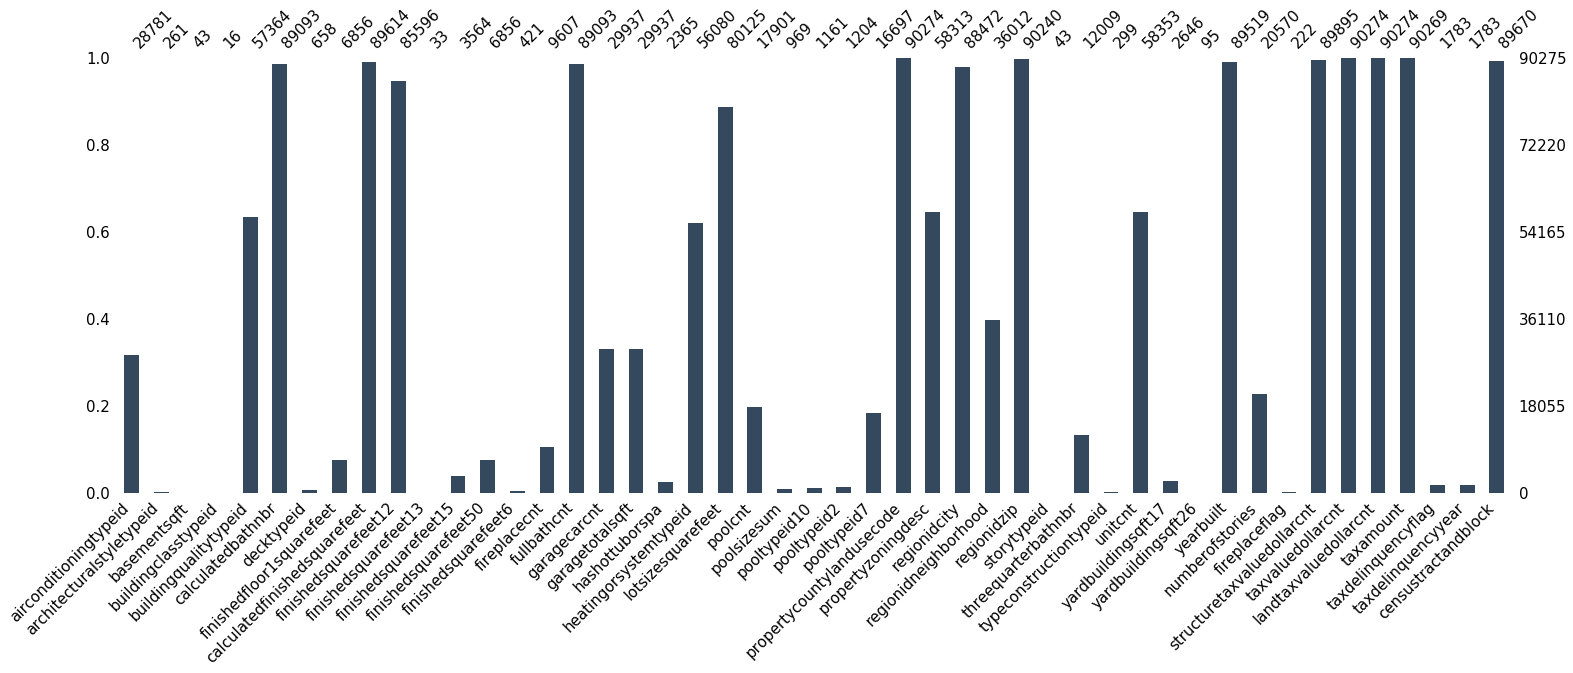

In [13]:
import missingno as msno

missingValueColumns = data.columns[data.isnull().any()].tolist()
msno.bar(data[missingValueColumns],\
            figsize=(25,8),color="#34495e",fontsize=15,labels=True,)

There's a ton of missing data here that we need to fix or discard. Let's take a deeper dive.

Let's start with data that's over 70% missing.

In [14]:
# backup copy before removing / adjusting values
df_original = data.copy(deep=True)

In [15]:
def displaymissing(df, useratio=True, percent=0.7, missratio='missing_ratio'):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['Feature', 'missing_count']
    missing_df[missratio] = missing_df['missing_count'] / df.shape[0]
    if (not useratio):
        percent = 0
    temp = missing_df[missing_df[missratio] > percent].sort_values(by=missratio, ascending=False)
    temp = pd.merge(temp, features, on='Feature')
    return temp
displaymissing(data)

,Feature,missing_count,missing_ratio,Description,dtype
0,buildingclasstypeid,90259,0.999823,"The building framing type (steel frame, wood frame, concrete/brick)",float64
1,finishedsquarefeet13,90242,0.999634,Perimeter living area,float64
2,basementsqft,90232,0.999524,Finished living area below or partially below ground level,float64
3,storytypeid,90232,0.999524,"Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.). See tab for details.",float64
4,yardbuildingsqft26,90180,0.998948,Storage shed/building in yard,float64
5,fireplaceflag,90053,0.997541,Is a fireplace present in this home,object
6,architecturalstyletypeid,90014,0.997109,"Architectural style of the home (i.e. ranch, colonial, split-level, etc…)",float64
7,typeconstructiontypeid,89976,0.996688,What type of construction material was used to construct the home,float64
8,finishedsquarefeet6,89854,0.995336,Base unfinished and finished area,float64
9,decktypeid,89617,0.992711,Type of deck (if any) present on parcel,float64


**'poolcnt', 'fireplacecnt'** are only missing because it was only filled in if they had them: 
* Number of pools on the lot (if any)
* Number of fireplaces in a home (if any)

Can also fill in **'fireplaceflag' and 'taxdelinquencyflag'**

In [16]:
def getvaluecounts(df, feature, normalize=True, limit=10):
    temp = df[feature].value_counts(normalize)
    if (len(temp) < 10):
        limit = len(temp)
    return temp.head(limit)

In [17]:
getvaluecounts(data, 'poolcnt')

1.0    1.0
Name: poolcnt, dtype: float64

In [18]:
getvaluecounts(data, 'fireplacecnt')

1.0    0.849901
2.0    0.115124
3.0    0.032476
4.0    0.002186
5.0    0.000312
Name: fireplacecnt, dtype: float64

In [19]:
getvaluecounts(data, 'fireplaceflag')

True    1.0
Name: fireplaceflag, dtype: float64

In [20]:
getvaluecounts(data, 'taxdelinquencyflag')

Y    1.0
Name: taxdelinquencyflag, dtype: float64

In [21]:
data.poolcnt = data.poolcnt.fillna(0)
data.fireplacecnt = data.fireplacecnt.fillna(0)
data.fireplaceflag = data.fireplaceflag.fillna(0)
data.taxdelinquencyflag = data.taxdelinquencyflag.fillna(0)

data.poolcnt = data.poolcnt.astype('int8')
data.fireplacecnt = data.fireplacecnt.astype('int8')
data.fireplaceflag = data.fireplaceflag.astype('bool')
data.taxdelinquencyflag = data.taxdelinquencyflag.astype('bool')


In [22]:
getvaluecounts(data, 'poolcnt')


0    0.801706
1    0.198294
Name: poolcnt, dtype: float64

In [23]:
getvaluecounts(data, 'fireplacecnt')


0    0.893581
1    0.090446
2    0.012251
3    0.003456
4    0.000233
5    0.000033
Name: fireplacecnt, dtype: float64

In [24]:
getvaluecounts(data, 'fireplaceflag')


False    0.997541
True     0.002459
Name: fireplaceflag, dtype: float64

In [25]:
getvaluecounts(data, 'taxdelinquencyflag')

False    0.980249
True     0.019751
Name: taxdelinquencyflag, dtype: float64

In [26]:
displaymissing(data)

,Feature,missing_count,missing_ratio,Description,dtype
0,buildingclasstypeid,90259,0.999823,"The building framing type (steel frame, wood frame, concrete/brick)",float64
1,finishedsquarefeet13,90242,0.999634,Perimeter living area,float64
2,basementsqft,90232,0.999524,Finished living area below or partially below ground level,float64
3,storytypeid,90232,0.999524,"Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.). See tab for details.",float64
4,yardbuildingsqft26,90180,0.998948,Storage shed/building in yard,float64
5,architecturalstyletypeid,90014,0.997109,"Architectural style of the home (i.e. ranch, colonial, split-level, etc…)",float64
6,typeconstructiontypeid,89976,0.996688,What type of construction material was used to construct the home,float64
7,finishedsquarefeet6,89854,0.995336,Base unfinished and finished area,float64
8,decktypeid,89617,0.992711,Type of deck (if any) present on parcel,float64
9,poolsizesum,89306,0.989266,Total square footage of all pools on property,float64


Let's try to look at all **features related to pool/spa:**

In [27]:
poolspafeature = ['pooltypeid7', 'pooltypeid2', 'pooltypeid10', 'poolsizesum', 'hashottuborspa']

missing = displaymissing(data)
missing[missing['Feature'].isin(poolspafeature)]

,Feature,missing_count,missing_ratio,Description,dtype
9,poolsizesum,89306,0.989266,Total square footage of all pools on property,float64
10,pooltypeid10,89114,0.987139,Spa or Hot Tub,float64
11,pooltypeid2,89071,0.986663,Pool with Spa/Hot Tub,float64
13,hashottuborspa,87910,0.973802,Does the home have a hot tub or spa,object
19,pooltypeid7,73578,0.815043,Pool without hot tub,float64


In [28]:
for feature in poolspafeature:
    print(feature)
    print(getvaluecounts(data, feature))
    print()

pooltypeid7
1.0    1.0
Name: pooltypeid7, dtype: float64

pooltypeid2
1.0    1.0
Name: pooltypeid2, dtype: float64

pooltypeid10
1.0    1.0
Name: pooltypeid10, dtype: float64

poolsizesum
450.0    0.108359
400.0    0.042312
800.0    0.040248
500.0    0.037152
600.0    0.036120
512.0    0.030960
480.0    0.027864
648.0    0.018576
420.0    0.017544
525.0    0.015480
Name: poolsizesum, dtype: float64

hashottuborspa
True    1.0
Name: hashottuborspa, dtype: float64



**Validation of pooltypeid7, "Pool without hot tub"**

pool count - pool with spa/hottub = pool without hot tub

In [29]:
data.poolcnt.value_counts()[1] - data.pooltypeid2.value_counts()

1.0    16697
Name: pooltypeid2, dtype: int64

There's already some feature engineering that's been done but it just needs to be cleaned up. For instance, they expand on combinations of haspool and hashottub to things like pool with / without hottub.

The feature names could be improved too. 

Additionally, poolsizesum should be dropped because too much of it is missing to impute reliably.

We can also drop poolcnt since the data is captured elsewhere.

In [30]:
#drop poolsizesum
data.drop("poolsizesum", axis=1, inplace=True)
data.drop("poolcnt", axis=1, inplace=True)

poolspafeature.remove("poolsizesum")

for feature in poolspafeature:
    data[feature] = data[feature].fillna(0)
    data[feature] = data[feature].astype('bool')

Rename features

In [31]:
pool_dict = {'pooltypeid10':'spaorhottub', 'pooltypeid2': 'poolwithspaorhottub', 'pooltypeid7':'poolwithouthottuborspa', 'hashottuborspa': 'hashottuborspa'}

data = data.rename(columns=pool_dict)

poolspafeature = list((pd.Series(poolspafeature)).map(pool_dict))

for feature in poolspafeature:
    print(feature)
    print(getvaluecounts(data, feature))
    print()

poolwithouthottuborspa
False    0.815043
True     0.184957
Name: poolwithouthottuborspa, dtype: float64

poolwithspaorhottub
False    0.986663
True     0.013337
Name: poolwithspaorhottub, dtype: float64

spaorhottub
False    0.987139
True     0.012861
Name: spaorhottub, dtype: float64

hashottuborspa
False    0.973802
True     0.026198
Name: hashottuborspa, dtype: float64



In [32]:
displaymissing(data)

,Feature,missing_count,missing_ratio,Description,dtype
0,buildingclasstypeid,90259,0.999823,"The building framing type (steel frame, wood frame, concrete/brick)",float64
1,finishedsquarefeet13,90242,0.999634,Perimeter living area,float64
2,basementsqft,90232,0.999524,Finished living area below or partially below ground level,float64
3,storytypeid,90232,0.999524,"Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.). See tab for details.",float64
4,yardbuildingsqft26,90180,0.998948,Storage shed/building in yard,float64
5,architecturalstyletypeid,90014,0.997109,"Architectural style of the home (i.e. ranch, colonial, split-level, etc…)",float64
6,typeconstructiontypeid,89976,0.996688,What type of construction material was used to construct the home,float64
7,finishedsquarefeet6,89854,0.995336,Base unfinished and finished area,float64
8,decktypeid,89617,0.992711,Type of deck (if any) present on parcel,float64
9,taxdelinquencyyear,88492,0.980249,Year for which the unpaid propert taxes were due,float64


**Shed/Deck/Patio** related variables have a lot of missing values but rather than throw them away we'll convert them to boolean.

Also, numberofstories will be imputed with mode (number of stories = 1).

In [33]:
sheddeckpatio = ['yardbuildingsqft26', 'decktypeid', 'yardbuildingsqft17']

missing = displaymissing(data)
missing[missing['Feature'].isin(sheddeckpatio)]

,Feature,missing_count,missing_ratio,Description,dtype
4,yardbuildingsqft26,90180,0.998948,Storage shed/building in yard,float64
8,decktypeid,89617,0.992711,Type of deck (if any) present on parcel,float64
10,yardbuildingsqft17,87629,0.970690,Patio in yard,float64


In [34]:
for feature in sheddeckpatio:
    print(feature)
    print(getvaluecounts(data, feature))
    print()

yardbuildingsqft26
120.0    0.063158
144.0    0.031579
60.0     0.031579
180.0    0.031579
125.0    0.031579
37.0     0.021053
204.0    0.021053
168.0    0.021053
88.0     0.021053
108.0    0.021053
Name: yardbuildingsqft26, dtype: float64

decktypeid
66.0    1.0
Name: decktypeid, dtype: float64

yardbuildingsqft17
240.0    0.041950
200.0    0.032880
300.0    0.024943
120.0    0.020786
180.0    0.019652
216.0    0.017007
288.0    0.016629
360.0    0.016629
400.0    0.013605
220.0    0.012472
Name: yardbuildingsqft17, dtype: float64



In [35]:
for feature in sheddeckpatio:
    data[feature] = data[feature].fillna(0)
    data = data.astype({feature : 'bool'})

In [36]:
deck_dict = {'yardbuildingsqft26':'shedflag', 'decktypeid': 'deckflag', 'yardbuildingsqft17':'patioflag'}

data = data.rename(columns=deck_dict)

sheddeckpatio = list((pd.Series(sheddeckpatio)).map(deck_dict))

for feature in sheddeckpatio:
    print(feature)
    print(getvaluecounts(data, feature))
    print()

shedflag
False    0.998948
True     0.001052
Name: shedflag, dtype: float64

deckflag
False    0.992711
True     0.007289
Name: deckflag, dtype: float64

patioflag
False    0.97069
True     0.02931
Name: patioflag, dtype: float64



In [37]:
# replace with mode
# should have at least one story per house
data.numberofstories.value_counts()

1.0    12016
2.0     8044
3.0      508
4.0        2
Name: numberofstories, dtype: int64

In [38]:
data['numberofstories'] = data['numberofstories'].fillna(data['numberofstories'].mode()[0])
data['numberofstories'].value_counts()

1.0    81721
2.0     8044
3.0      508
4.0        2
Name: numberofstories, dtype: int64

What's still missing...

In [39]:
displaymissing(data, False)

,Feature,missing_count,missing_ratio,Description,dtype
0,buildingclasstypeid,90259,0.999823,"The building framing type (steel frame, wood frame, concrete/brick)",float64
1,finishedsquarefeet13,90242,0.999634,Perimeter living area,float64
2,basementsqft,90232,0.999524,Finished living area below or partially below ground level,float64
3,storytypeid,90232,0.999524,"Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.). See tab for details.",float64
4,architecturalstyletypeid,90014,0.997109,"Architectural style of the home (i.e. ranch, colonial, split-level, etc…)",float64
5,typeconstructiontypeid,89976,0.996688,What type of construction material was used to construct the home,float64
6,finishedsquarefeet6,89854,0.995336,Base unfinished and finished area,float64
7,taxdelinquencyyear,88492,0.980249,Year for which the unpaid propert taxes were due,float64
8,finishedsquarefeet15,86711,0.960521,Total area,float64
9,finishedfloor1squarefeet,83419,0.924054,Size of the finished living area on the first (entry) floor of the home,float64


Let's choose one group of related features and focus on that.

**region features**

In [40]:
# Columns regionidcity, regionidneighborhood and regionidzip can be given some random 
# values based on the other values in the respective columns.
region_features = ['regionidcity', 'regionidneighborhood', 'regionidzip']

missing = displaymissing(data, False)
missing[missing['Feature'].isin(region_features)]

,Feature,missing_count,missing_ratio,Description,dtype
15,regionidneighborhood,54263,0.601086,Neighborhood in which the property is located,float64
22,regionidcity,1803,0.019972,City in which the property is located (if any),float64
29,regionidzip,35,0.000388,Zip code in which the property is located,float64


In [41]:
for feature in region_features:
    print(feature)
    print(getvaluecounts(data, feature))
    print()

regionidcity
12447.0    0.232379
46298.0    0.033909
52650.0    0.024098
54311.0    0.024053
5534.0     0.023002
40227.0    0.022030
16764.0    0.020345
25218.0    0.017927
34278.0    0.015632
27110.0    0.014310
Name: regionidcity, dtype: float64

regionidneighborhood
118208.0    0.021465
27080.0     0.020965
48570.0     0.020910
37739.0     0.019854
48200.0     0.018133
268496.0    0.017522
51906.0     0.016911
54300.0     0.014995
113455.0    0.014690
33183.0     0.013801
Name: regionidneighborhood, dtype: float64

regionidzip
97319.0    0.010106
96987.0    0.009996
96974.0    0.009131
97329.0    0.008422
97318.0    0.008045
97118.0    0.007968
97328.0    0.007801
96993.0    0.007613
96996.0    0.007092
96962.0    0.006915
Name: regionidzip, dtype: float64



These have a lot of values and there may be a way to look up the value based on online databases but for now we'll replace with random values.

In [42]:
# def fill_with_random(df2, column):
#     '''Fill `df2`'s column with name `column` with random data based on non-NaN data from `column`'''
#     df = df2.copy()
#     df[column] = df[column].apply(lambda x: np.random.choice(df[column].dropna().values) if np.isnan(x) else x)
#     return df

for feature in region_features:
    data[feature] = data[feature].fillna(0)
    
# check if nan values are present or not
print(data['regionidcity'].isnull().sum())
print(data['regionidneighborhood'].isnull().sum())
print(data['regionidzip'].isnull().sum())

0
0
0


**Bath features**

In [43]:
bath_features = ['bathroomcnt', 'calculatedbathnbr', 'fullbathcnt', 'threequarterbathnbr']

missing = displaymissing(data)
missing[missing['Feature'].isin(bath_features)]

,Feature,missing_count,missing_ratio,Description,dtype
11,threequarterbathnbr,78266,0.866973,Number of 3/4 bathrooms in house (shower + sink + toilet),float64


In [44]:
features[features['Feature'].isin(bath_features)]

,Feature,Description,dtype
3,bathroomcnt,Number of bathrooms in home including fractional bathrooms,float64
7,calculatedbathnbr,Number of bathrooms in home including fractional bathroom,float64
20,fullbathcnt,"Number of full bathrooms (sink, shower + bathtub, and toilet) present in home",float64
9,threequarterbathnbr,Number of 3/4 bathrooms in house (shower + sink + toilet),float64


In [45]:
for feature in bath_features:
    print(feature)
    print(getvaluecounts(data, feature))
    print()

bathroomcnt
2.0    0.404697
3.0    0.220947
1.0    0.166547
2.5    0.089626
4.0    0.041462
1.5    0.018178
0.0    0.012905
5.0    0.012650
3.5    0.012085
4.5    0.008806
Name: bathroomcnt, dtype: float64

calculatedbathnbr
2.0    0.410066
3.0    0.223878
1.0    0.168756
2.5    0.090737
4.0    0.042012
1.5    0.018363
5.0    0.012818
3.5    0.012212
4.5    0.008901
6.0    0.005028
Name: calculatedbathnbr, dtype: float64

fullbathcnt
2.0     0.500993
3.0     0.236102
1.0     0.187119
4.0     0.050969
5.0     0.015624
6.0     0.005500
7.0     0.001830
8.0     0.001257
9.0     0.000370
10.0    0.000146
Name: fullbathcnt, dtype: float64

threequarterbathnbr
1.0    0.991923
2.0    0.007494
3.0    0.000500
4.0    0.000083
Name: threequarterbathnbr, dtype: float64



calculatedbathnbr : Number of bathrooms in home including fractional bathroom

This feature is the most representative so we'll remove the others.

In [46]:
bath_features = ['bathroomcnt', 'calculatedbathnbr', 'fullbathcnt', 'threequarterbathnbr']

for feature in bath_features:
    if (feature == 'calculatedbathnbr'):
        continue
    data.drop(feature, axis = 1, inplace=True)

**unitcnt**

In [47]:
unit_feature = ['unitcnt']

missing = displaymissing(data, False)
missing[missing['Feature'].isin(unit_feature)]

,Feature,missing_count,missing_ratio,Description,dtype
17,unitcnt,31922,0.353608,"Number of units the structure is built into (i.e. 2 = duplex, 3 = triplex, etc...)",float64


In [48]:
for feature in unit_feature:
    print(feature)
    print(getvaluecounts(data, feature))
    print()

unitcnt
1.0      0.934022
2.0      0.040341
4.0      0.014926
3.0      0.010608
6.0      0.000017
5.0      0.000017
9.0      0.000017
11.0     0.000017
143.0    0.000017
70.0     0.000017
Name: unitcnt, dtype: float64



Assume single family home is the most common. Although this could be validated by checking something like number of bathrooms being too high, but hard to determine what that limit would be.

In [49]:
for feature in unit_feature:
    data[feature] = data[feature].fillna(data[feature].mode()[0])

for feature in unit_feature:
    print(feature)
    print(getvaluecounts(data, feature))
    print()

unitcnt
1.0      0.957353
2.0      0.026076
4.0      0.009648
3.0      0.006857
6.0      0.000011
5.0      0.000011
9.0      0.000011
11.0     0.000011
143.0    0.000011
70.0     0.000011
Name: unitcnt, dtype: float64



**propertycountylandusecode and propertyzoningdesc**

In [50]:
property_features = ['propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc']

missing = displaymissing(data, False)
missing[missing['Feature'].isin(property_features)]

,Feature,missing_count,missing_ratio,Description,dtype
16,propertyzoningdesc,31962,0.354052,Description of the allowed land uses (zoning) for that property,object
25,propertycountylandusecode,1,0.000011,County land use code i.e. it's zoning at the county level,object


In [51]:
for feature in property_features:
    print(feature)
    print(getvaluecounts(data, feature))
    print()

propertycountylandusecode
0100    0.341693
122     0.170403
010C    0.113698
0101    0.082360
34      0.065866
1111    0.043013
1       0.032291
010E    0.025323
010D    0.024470
0200    0.023850
Name: propertycountylandusecode, dtype: float64

propertylandusetypeid
261.0    0.671692
266.0    0.252728
246.0    0.026320
269.0    0.025854
248.0    0.009737
247.0    0.006968
265.0    0.003944
263.0    0.000930
260.0    0.000687
275.0    0.000510
Name: propertylandusetypeid, dtype: float64

propertyzoningdesc
LAR1       0.131669
LAR3       0.048034
LARS       0.025775
LBR1N      0.025020
LARD1.5    0.022379
LAR2       0.022071
SCUR2      0.018932
LARD2      0.016514
LARA       0.014594
LARE11     0.012279
Name: propertyzoningdesc, dtype: float64



In [52]:
for feature in property_features:
    data[feature].fillna(data[feature].mode()[0], inplace =True)


In [53]:
# Since there is only one missing value in this column we will replace it manually with a random value
print(data['propertycountylandusecode'].isnull().sum())
print(data['propertylandusetypeid'].isnull().sum())
print(data['propertyzoningdesc'].isnull().sum())

0
0
0


**garage features**

In [54]:
garage_features = ['garagecarcnt', 'garagetotalsqft']

In [55]:
missing = displaymissing(data, False)
missing[missing['Feature'].isin(garage_features)]

,Feature,missing_count,missing_ratio,Description,dtype
12,garagetotalsqft,60338,0.66838,Total number of square feet of all garages on lot including an attached garage,float64
13,garagecarcnt,60338,0.66838,Total number of garages on the lot including an attached garage,float64


In [56]:
for feature in garage_features:
    print(feature)
    print(getvaluecounts(data, feature))
    print()

garagecarcnt
2.0    0.732939
1.0    0.223102
3.0    0.022147
0.0    0.009687
4.0    0.008752
5.0    0.001804
6.0    0.000534
7.0    0.000367
8.0    0.000234
9.0    0.000200
Name: garagecarcnt, dtype: float64

garagetotalsqft
0.0      0.307613
400.0    0.032401
441.0    0.026589
360.0    0.024552
462.0    0.024318
460.0    0.023316
440.0    0.023215
420.0    0.021011
483.0    0.016501
480.0    0.011090
Name: garagetotalsqft, dtype: float64



There's a lot of missing data here, 66%, best to fill it with 0, rather than assume anything.

In [57]:
for feature in garage_features:
    data[feature] = data[feature].fillna(0)

**sqft_features** Too many missing values for these.

In [58]:
sqft_features = ['basementsqft', 'finishedfloor1squarefeet', 'finishedsquarefeet50', 'finishedsquarefeet15', 'finishedsquarefeet6', 'finishedsquarefeet13']

missing = displaymissing(data, False)
missing[missing['Feature'].isin(sqft_features)]

,Feature,missing_count,missing_ratio,Description,dtype
1,finishedsquarefeet13,90242,0.999634,Perimeter living area,float64
2,basementsqft,90232,0.999524,Finished living area below or partially below ground level,float64
6,finishedsquarefeet6,89854,0.995336,Base unfinished and finished area,float64
8,finishedsquarefeet15,86711,0.960521,Total area,float64
9,finishedsquarefeet50,83419,0.924054,Size of the finished living area on the first (entry) floor of the home,float64
10,finishedfloor1squarefeet,83419,0.924054,Size of the finished living area on the first (entry) floor of the home,float64


These are the square feet features without a ton of missing data, which will be sufficient for the "finished square feet" related ones. It looks like basement sqft isn't captured elsewhere unfortunately.

In [59]:
features[features['Feature'].isin(['finishedsquarefeet12', 'calculatedfinishedsquarefeet'])]

,Feature,Description,dtype
11,calculatedfinishedsquarefeet,Calculated total finished living area of the home,float64
13,finishedsquarefeet12,Finished living area,float64


In [60]:
for feature in sqft_features:
    data.drop(feature, axis = 1, inplace=True)

**other_high_missing_features**

In [61]:
other_high_missing_features = ['buildingclasstypeid', 'storytypeid', 'architecturalstyletypeid', 'typeconstructiontypeid', 'taxdelinquencyyear']

missing = displaymissing(data, False)
missing[missing['Feature'].isin(other_high_missing_features)]


,Feature,missing_count,missing_ratio,Description,dtype
0,buildingclasstypeid,90259,0.999823,"The building framing type (steel frame, wood frame, concrete/brick)",float64
1,storytypeid,90232,0.999524,"Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.). See tab for details.",float64
2,architecturalstyletypeid,90014,0.997109,"Architectural style of the home (i.e. ranch, colonial, split-level, etc…)",float64
3,typeconstructiontypeid,89976,0.996688,What type of construction material was used to construct the home,float64
4,taxdelinquencyyear,88492,0.980249,Year for which the unpaid propert taxes were due,float64


In [62]:
for feature in other_high_missing_features:
    data.drop(feature, axis = 1, inplace=True)

**Cooling, heating, building quality features**

In [63]:
coolingheatingbuilding_features = ['airconditioningtypeid', 'heatingorsystemtypeid', 'buildingqualitytypeid']

missing = displaymissing(data, False)
missing[missing['Feature'].isin(coolingheatingbuilding_features)]

,Feature,missing_count,missing_ratio,Description,dtype
0,airconditioningtypeid,61494,0.681185,Type of cooling system present in the home (if any),float64
1,heatingorsystemtypeid,34195,0.378787,Type of home heating system,float64
2,buildingqualitytypeid,32911,0.364564,Overall assessment of condition of the building from best (lowest) to worst (highest),float64


In [64]:
for feature in coolingheatingbuilding_features:
    data[feature] = data[feature].fillna(data[feature].mode()[0])


**yearbuilt**
* There are 756 missing values in the column yearbuilt
* It appears that 2016 is the missing year

In [65]:
data['yearbuilt'].sort_values().unique()

array([1885., 1886., 1887., 1888., 1890., 1891., 1892., 1893., 1894.,
       1895., 1896., 1897., 1898., 1899., 1900., 1901., 1902., 1903.,
       1904., 1905., 1906., 1907., 1908., 1909., 1910., 1911., 1912.,
       1913., 1914., 1915., 1916., 1917., 1918., 1919., 1920., 1921.,
       1922., 1923., 1924., 1925., 1926., 1927., 1928., 1929., 1930.,
       1931., 1932., 1933., 1934., 1935., 1936., 1937., 1938., 1939.,
       1940., 1941., 1942., 1943., 1944., 1945., 1946., 1947., 1948.,
       1949., 1950., 1951., 1952., 1953., 1954., 1955., 1956., 1957.,
       1958., 1959., 1960., 1961., 1962., 1963., 1964., 1965., 1966.,
       1967., 1968., 1969., 1970., 1971., 1972., 1973., 1974., 1975.,
       1976., 1977., 1978., 1979., 1980., 1981., 1982., 1983., 1984.,
       1985., 1986., 1987., 1988., 1989., 1990., 1991., 1992., 1993.,
       1994., 1995., 1996., 1997., 1998., 1999., 2000., 2001., 2002.,
       2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010., 2011.,
       2012., 2013.,

In [66]:
# Fill NaN with the year 2016
data['yearbuilt'] = data['yearbuilt'].fillna(2016)

**censustractandblock**
* censustractandblock - Census tract and block ID combined - also contains blockgroup assignment by extension

This may be useful to fix other columns but we're going to drop it since it's basically a unique identifier.


In [67]:
getvaluecounts(data,'censustractandblock')

6.037920e+13    0.000691
6.059032e+13    0.000658
6.037137e+13    0.000546
6.059063e+13    0.000513
6.037277e+13    0.000502
6.111007e+13    0.000491
6.037577e+13    0.000468
6.037274e+13    0.000457
6.059052e+13    0.000457
6.037920e+13    0.000435
Name: censustractandblock, dtype: float64

In [68]:
data['censustractandblock'].nunique()

42398

In [69]:
# First, lets check the correlation between censustractandblock and rawcensustrackandblock
data['censustractandblock'].corr(data['rawcensustractandblock'])

0.9998219419915642

In [70]:
data.drop('censustractandblock', axis=1, inplace=True)
data.drop('rawcensustractandblock', axis=1, inplace=True)

In [71]:
still_missing = list(displaymissing(data, False)["Feature"].values)
missing = displaymissing(data, False)
missing[missing['Feature'].isin(still_missing)]

,Feature,missing_count,missing_ratio,Description,dtype
0,lotsizesquarefeet,10150,0.112434,Area of the lot in square feet,float64
1,finishedsquarefeet12,4679,0.051831,Finished living area,float64
2,calculatedbathnbr,1182,0.013093,Number of bathrooms in home including fractional bathroom,float64
3,calculatedfinishedsquarefeet,661,0.007322,Calculated total finished living area of the home,float64
4,structuretaxvaluedollarcnt,380,0.004209,The assessed value of the built structure on the parcel,float64
5,taxamount,6,0.000066,The total property tax assessed for that assessment year,float64
6,taxvaluedollarcnt,1,0.000011,The total tax assessed value of the parcel,float64
7,landtaxvaluedollarcnt,1,0.000011,The assessed value of the land area of the parcel,float64


So far we've only used mode or filled missing with zero, which would result in the same vlaues in the validation/test set. However, all the columns that remain need to be replaced with mean().

Let's do a little more cleanup of the data before we do that.

In [72]:
object_features = list(data.select_dtypes(include='object').columns)

for feature in object_features:
    print(feature)
    print(getvaluecounts(data, feature))
    print()

transactiondate
2016-07-29    0.010080
2016-04-29    0.009992
2016-09-30    0.009903
2016-06-30    0.009682
2016-05-27    0.009560
2016-08-31    0.008164
2016-07-01    0.008097
2016-03-31    0.008009
2016-07-15    0.007677
2016-06-24    0.007366
Name: transactiondate, dtype: float64

propertycountylandusecode
0100    0.341700
122     0.170402
010C    0.113697
0101    0.082359
34      0.065865
1111    0.043013
1       0.032290
010E    0.025323
010D    0.024470
0200    0.023849
Name: propertycountylandusecode, dtype: float64

propertyzoningdesc
LAR1       0.439103
LAR3       0.031027
LARS       0.016649
LBR1N      0.016162
LARD1.5    0.014456
LAR2       0.014256
SCUR2      0.012229
LARD2      0.010667
LARA       0.009427
LARE11     0.007931
Name: propertyzoningdesc, dtype: float64



**Edit 'transactiondate'**

In [73]:
data['transactiondate'] = pd.to_datetime(data['transactiondate'])

# Create two additional columns each for the month and day
data['transaction_month'] = data.transactiondate.dt.month.astype(np.int64)
data['transaction_day'] = data.transactiondate.dt.weekday.astype(np.int64)

# Drop the 'transactiondate' column 
data = data.drop('transactiondate', axis = 1)

In [74]:
from sklearn.model_selection import train_test_split

train_cols = [col for col in data.columns if col not in ['logerror']]

# Note: XGBoost does not require normalization    
train = data[train_cols]
test = data["logerror"]

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2, random_state=24)

data_combined = [X_train, X_test]

In [75]:
for dataset in data_combined:
    missing = list(displaymissing(dataset, False)["Feature"].values)
    for feature in missing:
        dataset[feature] = dataset[feature].fillna(dataset[feature].mean())
        


In [76]:

string_features = ['airconditioningtypeid', 'assessmentyear', 'buildingqualitytypeid', 'fips', 'heatingorsystemtypeid', 'parcelid', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'unitcnt', 'yearbuilt', 'propertycountylandusecode', 'propertyzoningdesc']
int8_features = ['bedroomcnt', 'fireplacecnt', 'garagecarcnt', 'numberofstories', 'roomcnt']
int32_features = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'garagetotalsqft', 'landtaxvaluedollarcnt', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt']
float32_features = ['calculatedbathnbr', 'latitude', 'longitude', 'taxamount']
bool_features = ['fireplaceflag', 'hashottuborspa', 'taxdelinquencyflag']

dtypes = [string_features, int8_features, int32_features, float32_features, bool_features]

types = ['str', 'int8', 'int32', 'float32', 'bool']
i = 0
for data in data_combined:
    for type_list in dtypes:
#         print(type_list)
        for feature in type_list:
#             print(feature)
#             print(data.head(10))
            data[feature] = data[feature].astype(types[i])
        i += 1
    i = 0

In [77]:

string_features = ['airconditioningtypeid', 'assessmentyear', 'buildingqualitytypeid', 'fips', 'heatingorsystemtypeid', 'parcelid', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'unitcnt', 'yearbuilt', 'propertycountylandusecode', 'propertyzoningdesc']
int8_features = ['bedroomcnt', 'fireplacecnt', 'garagecarcnt', 'numberofstories', 'roomcnt']
int32_features = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'garagetotalsqft', 'landtaxvaluedollarcnt', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt']
float32_features = ['calculatedbathnbr', 'latitude', 'longitude', 'taxamount']
bool_features = ['fireplaceflag', 'hashottuborspa', 'taxdelinquencyflag']

dtypes = [string_features, int8_features, int32_features, float32_features, bool_features]

types = ['string', 'int8', 'int32', 'float32', 'bool']
i = 0
for data in data_combined:
    for type_list in dtypes:
#         print(type_list)
        for feature in type_list:
#             print(feature)
#             print(data.head(10))
            data[feature] = data[feature].astype(types[i])
        i += 1
    i = 0

**Let's see what features we have left**

In [78]:
temp = pd.DataFrame({'Feature': X_train.dtypes.sort_index().index, 'dtype': X_train.dtypes.sort_index()})
temp.reset_index(drop=True, inplace=True)
temp = temp.astype({'Feature' : 'string'})
temp.head(5)

,Feature,dtype
0,airconditioningtypeid,string
1,assessmentyear,string
2,bedroomcnt,int8
3,buildingqualitytypeid,string
4,calculatedbathnbr,float32


In [79]:
features = pd.merge(feature_descr, temp)
features = features.sort_values(by='Feature')
features

,Feature,Description,dtype
0,airconditioningtypeid,Type of cooling system present in the home (if any),string
32,assessmentyear,The year of the property tax assessment,string
1,bedroomcnt,Number of bedrooms in home,int8
2,buildingqualitytypeid,Overall assessment of condition of the building from best (lowest) to worst (highest),string
3,calculatedbathnbr,Number of bathrooms in home including fractional bathroom,float32
4,calculatedfinishedsquarefeet,Calculated total finished living area of the home,int32
5,finishedsquarefeet12,Finished living area,int32
6,fips,Federal Information Processing Standard code - see https://en.wikipedia.org/wiki/FIPS_county_code for more details,string
7,fireplacecnt,Number of fireplaces in a home (if any),int8
8,fireplaceflag,Is a fireplace present in this home,bool


In [80]:
displaymissing(X_train, False)

,missing_count,missing_ratio,Feature,Description,dtype


In [81]:
displaymissing(X_test, False)

,missing_count,missing_ratio,Feature,Description,dtype


# EDA continued

temporarily recombine train and test

In [82]:
df = X_train.copy(deep=True)

In [83]:
df['logerror'] = y_train.values

In [84]:
df.describe(include='all')

,parcelid,airconditioningtypeid,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,deckflag,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fireplacecnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,spaorhottub,poolwithspaorhottub,poolwithouthottuborspa,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,patioflag,shedflag,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,transaction_month,transaction_day,logerror
count,72220,72220,72220.000000,72220,72220.000000,72220,72220.000000,72220.000000,72220,72220.000000,72220.000000,72220.000000,72220,72220,7.222000e+04,7.222000e+04,7.222000e+04,72220,72220,72220,72220,72220,72220,72220,72220,72220,72220,72220.000000,72220,72220,72220,72220,72220.000000,72220,7.222000e+04,7.222000e+04,72220,7.222000e+04,72220.000000,72220,72220.000000,72220.000000,72220.000000
unique,72138,6,NaN,8,NaN,2,NaN,NaN,3,NaN,NaN,NaN,2,12,NaN,NaN,NaN,2,2,2,74,14,1869,178,3,486,389,NaN,7,2,2,131,NaN,2,NaN,NaN,1,NaN,NaN,2,NaN,NaN,NaN
top,11842707,1.0,NaN,7.0,NaN,False,NaN,NaN,6037.0,NaN,NaN,NaN,False,2.0,NaN,NaN,NaN,False,False,False,0100,261.0,LAR1,12447.0,3101.0,0.0,96987.0,NaN,1.0,False,False,1955.0,NaN,False,NaN,NaN,2015.0,NaN,NaN,False,NaN,NaN,NaN
freq,3,70542,NaN,49857,NaN,71697,NaN,NaN,46802,NaN,NaN,NaN,70341,57998,NaN,NaN,NaN,71303,71258,58856,24608,48406,31783,16390,46802,43458,729,NaN,69141,70083,72142,1815,NaN,72037,NaN,NaN,72220,NaN,NaN,70781,NaN,NaN,NaN
mean,NaN,NaN,3.029701,NaN,2.307840,NaN,1771.715785,1743.491761,NaN,0.126876,0.602645,114.657948,NaN,NaN,3.400584e+07,-1.182056e+08,2.929238e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.484935,NaN,NaN,NaN,NaN,1.100706,NaN,1.799040e+05,4.557947e+05,NaN,2.766604e+05,5965.705078,NaN,5.845818,2.334423,0.011660
std,NaN,NaN,1.154277,NaN,0.966548,NaN,924.448974,884.718717,NaN,0.399192,0.925671,224.861839,NaN,NaN,2.647028e+05,3.614912e+05,1.177198e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.823818,NaN,NaN,NaN,NaN,0.319423,NaN,2.095118e+05,5.519322e+05,NaN,3.975277e+05,6828.805664,NaN,2.812900,1.432904,0.158193
min,NaN,NaN,0.000000,NaN,1.000000,NaN,2.000000,2.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,3.333930e+07,-1.194479e+08,1.670000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000e+02,2.200000e+01,NaN,2.200000e+01,49.080002,NaN,1.000000,0.000000,-3.194000
25%,NaN,NaN,2.000000,NaN,2.000000,NaN,1188.000000,1192.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,3.381133e+07,-1.184120e+08,5.974000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000,NaN,8.162400e+04,1.987912e+05,NaN,8.216875e+04,2872.454956,NaN,4.000000,1.000000,-0.026300
50%,NaN,NaN,3.000000,NaN,2.000000,NaN,1545.000000,1560.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,3.402123e+07,-1.181731e+08,7.574500e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000,NaN,1.328935e+05,3.421720e+05,NaN,1.924475e+05,4537.090088,NaN,6.000000,2.000000,0.006000
75%,NaN,NaN,4.000000,NaN,3.000000,NaN,2084.000000,2008.000000,NaN,0.000000,2.000000,0.000000,NaN,NaN,3.417278e+07,-1.179224e+08,2.223450e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000,NaN,2.099000e+05,5.395732e+05,NaN,3.440000e+05,6888.272705,NaN,8.000000,4.000000,0.039200


In [85]:
def dropfeature(feature, axis=1):
    df.drop([feature], axis=axis, inplace = True)
    X_test.drop([feature], axis=axis, inplace = True)

In [86]:
# basically a unique identifier
dropfeature('parcelid')

**COLUMNS WITH NON-VARIANCE**

In [87]:
count = 0
for c in list(df):
    if (len(df[c].unique()) == 1):
        print(c)
        count+=1
print(count)

assessmentyear
1


In [88]:
dropfeature('assessmentyear')

In [89]:
# duplicate feature other feature is 'hasspaorhottub'
# hasspaorhottub kept since pool features seem to agree with one another
dropfeature('poolwithspaorhottub')

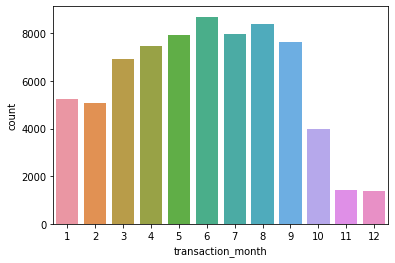

In [90]:
sns.countplot(x = 'transaction_month', data = df)

* It appears that more people bought bouses in the Spring/Summer than Fall/Winter.
* We will create a new feature called 'season' to capture this impact

In [91]:
def seas(x):
    if 2 < x < 6:    # March to May is Spring
        return 1    
    elif 5 < x < 9:  # June to August is Summer
        return 2       
    elif 8 < x < 12: # September to November is Fall
        return 3
    else:
        return 4     # December to February is Winter

df['season'] = df['transaction_month'].apply(seas)
df['season'] = df['season'].astype('str')
df['season'] = df['season'].astype('string')

X_test['season'] = X_test['transaction_month'].apply(seas)
X_test['season'] = X_test['season'].astype('str')
X_test['season'] = X_test['season'].astype('string')

([<matplotlib.axis.XTick at 0x1cf74cc0808>,
 <a list of 4 Text xticklabel objects>)

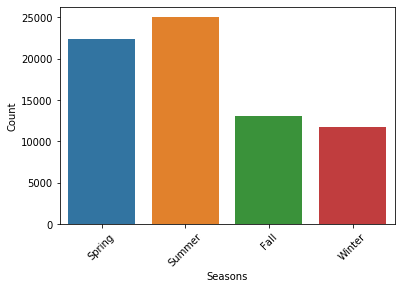

In [92]:
ax = sns.countplot(x = 'season', data = df)
ax.set(xlabel='Seasons', ylabel='Count')
season_list=['Spring','Summer','Fall','Winter']
plt.xticks(range(4), season_list, rotation=45)

([<matplotlib.axis.XTick at 0x1cf74d20ec8>,
 <a list of 7 Text xticklabel objects>)

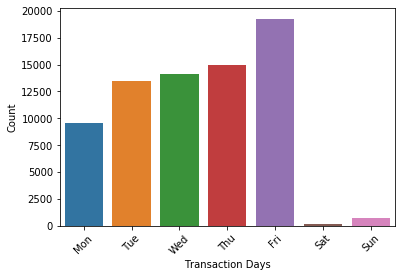

In [93]:
ax = sns.countplot(x = 'transaction_day', data = df)
ax.set(xlabel='Transaction Days', ylabel='Count')
days_list=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xticks(range(len(days_list)), days_list, rotation=45)

* Almost all houses were bought on weekdays
* We will make a new feature to capture this impact

In [94]:
def weekday_transaction(x):
    if 4 < x <= 6:      # Weekend
        return True        
    else:               # Weekday
        return False        

df['weekday_trans'] = df['transaction_day'].apply(weekday_transaction)
X_test['weekday_trans'] = X_test['transaction_day'].apply(weekday_transaction)

In [95]:
df['ExtraSpace'] = df['lotsizesquarefeet'] - df['calculatedfinishedsquarefeet'] 
X_test['ExtraSpace'] = X_test['lotsizesquarefeet'] - X_test['calculatedfinishedsquarefeet'] 

In [96]:
# Ratio of tax of property over parcel
#df['ValueRatio'] = df['taxvaluedollarcnt']/df['taxamount']

# TotalTaxScore
df['TaxScore'] = df['taxvaluedollarcnt']/df['taxamount']
X_test['TaxScore'] = X_test['taxvaluedollarcnt']/X_test['taxamount']


# Number of properties in the zip
zip_count = df['regionidzip'].value_counts().to_dict()
zip_count = X_test['regionidzip'].value_counts().to_dict()

df['zip_count'] = df['regionidzip'].map(zip_count)
X_test['zip_count'] = X_test['regionidzip'].map(zip_count)


#Number of properties in the city
city_count = df['regionidcity'].value_counts().to_dict()
city_count = X_test['regionidcity'].value_counts().to_dict()

df['city_count'] = df['regionidcity'].map(city_count)
X_test['city_count'] = X_test['regionidcity'].map(city_count)


#Number of properties in the city
region_count = df['regionidcounty'].value_counts().to_dict()
region_count = X_test['regionidcounty'].value_counts().to_dict()

df['county_count'] = df['regionidcounty'].map(region_count)
X_test['county_count'] = X_test['regionidcounty'].map(region_count)

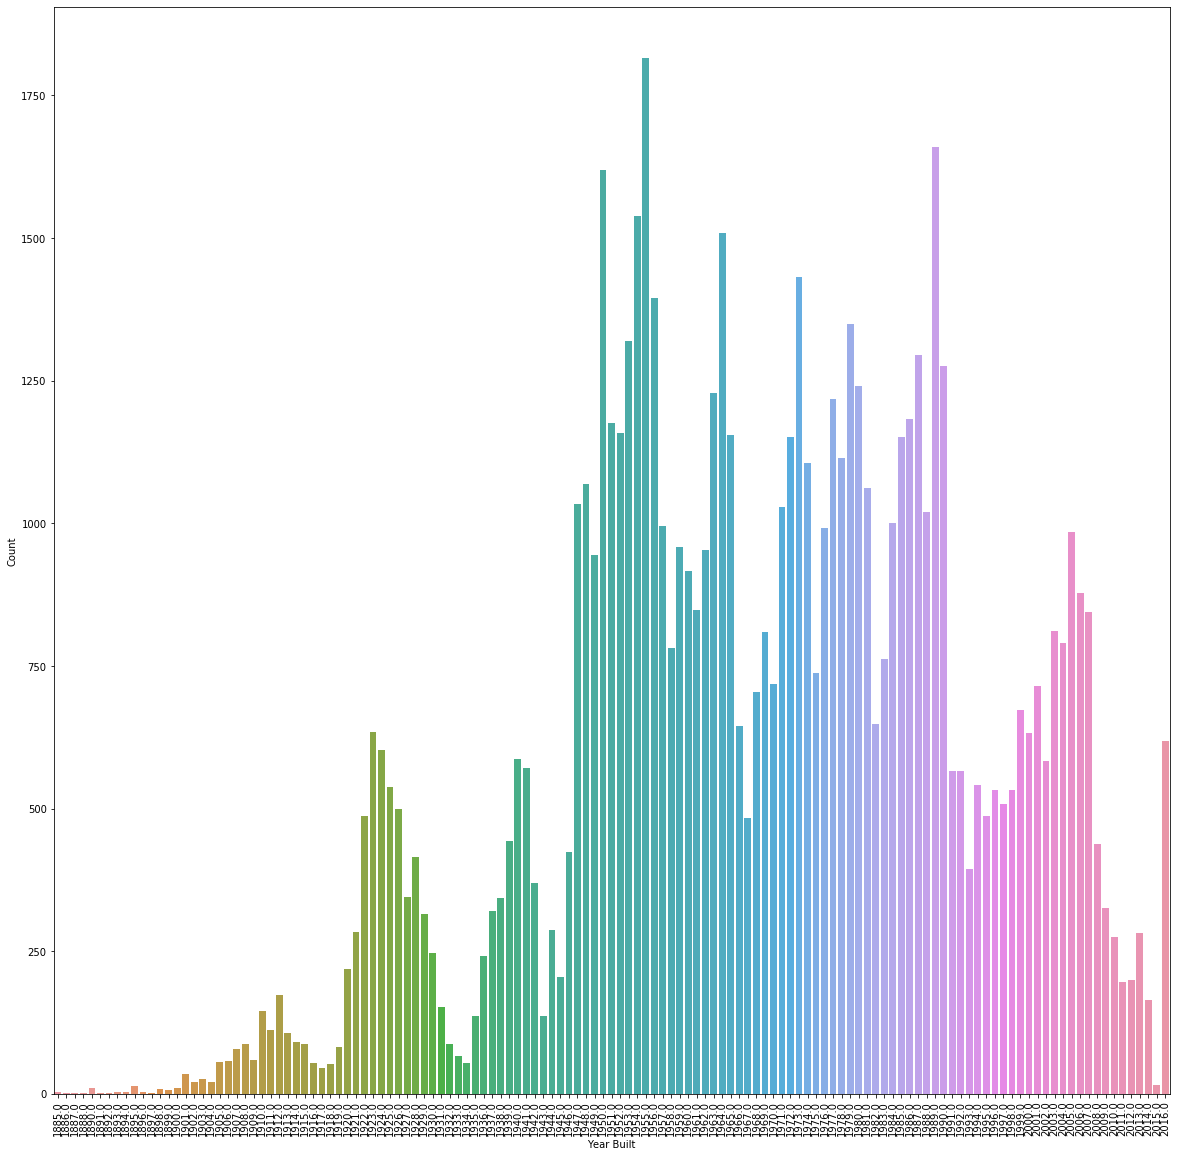

In [97]:
from matplotlib import pyplot
alist = []
alist = list(df['yearbuilt'].unique())
alist.sort()
fig, ax = pyplot.subplots(figsize=(20, 20))
ax = sns.countplot(x = 'yearbuilt', data = df)
ax.set(xlabel='Year Built', ylabel='Count')
plt.xticks(range(len(alist)), alist, rotation=90)
plt.show()

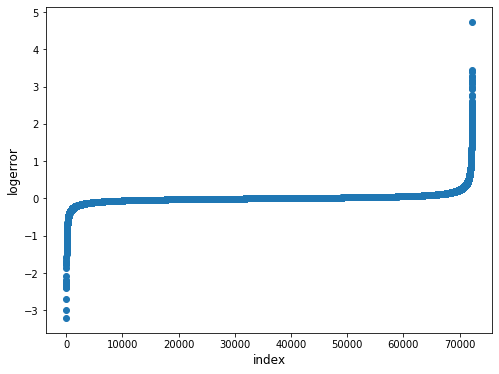

In [98]:
plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

What we see is that the log error values look fairly balanced, with some outliers.

What you want for the residuals for regression is for them to be normally distributed.

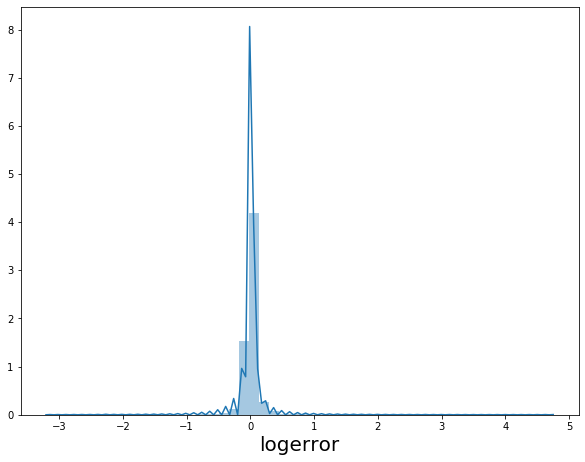

In [99]:
plt.figure(figsize=(10,7.5))
sns.distplot(df.logerror.values, kde=True)
plt.xlabel('logerror', fontsize=20)
plt.show()

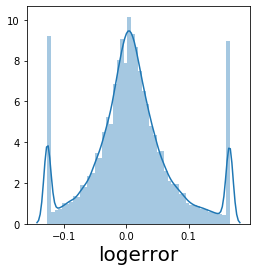

In [100]:
df_temp = df.copy(deep=True)

ulimit = np.percentile(df_temp.logerror.values, 95)
llimit = np.percentile(df_temp.logerror.values, 5)
df_temp.logerror.loc[df_temp.logerror > ulimit] = ulimit
df_temp.logerror.loc[df_temp.logerror < llimit] = llimit


# from scipy.stats import norm
# quantile_vect = np.linspace(-4, 4, 160)

# # Get PDF for normal distribution, mean, stdev defaults (0, 1)
# pdf_norm = norm.pdf(quantile_vect)

plt.figure(figsize=(4,4))
sns.distplot(df_temp.logerror.values, kde=True)
# plt.plot(quantile_vect, pdf_norm)
plt.xlabel('logerror', fontsize=20)
plt.show()

In [101]:
print('Correlation with Log Error')
print(df.corr(method='pearson').drop(['logerror']).sort_values('logerror', ascending=False)['logerror'])


Correlation with Log Error
finishedsquarefeet12            0.040124
calculatedfinishedsquarefeet    0.039250
calculatedbathnbr               0.030295
bedroomcnt                      0.026076
structuretaxvaluedollarcnt      0.018676
taxdelinquencyflag              0.015144
TaxScore                        0.009600
patioflag                       0.009451
garagetotalsqft                 0.008927
fireplacecnt                    0.008217
numberofstories                 0.007952
taxvaluedollarcnt               0.007526
transaction_month               0.006661
garagecarcnt                    0.006421
roomcnt                         0.005475
latitude                        0.004999
lotsizesquarefeet               0.004017
ExtraSpace                      0.003708
fireplaceflag                   0.000976
deckflag                        0.000233
landtaxvaluedollarcnt          -0.000185
shedflag                       -0.001470
longitude                      -0.003476
spaorhottub                   

Everything is relatively uncorrelated to each other, which is good.

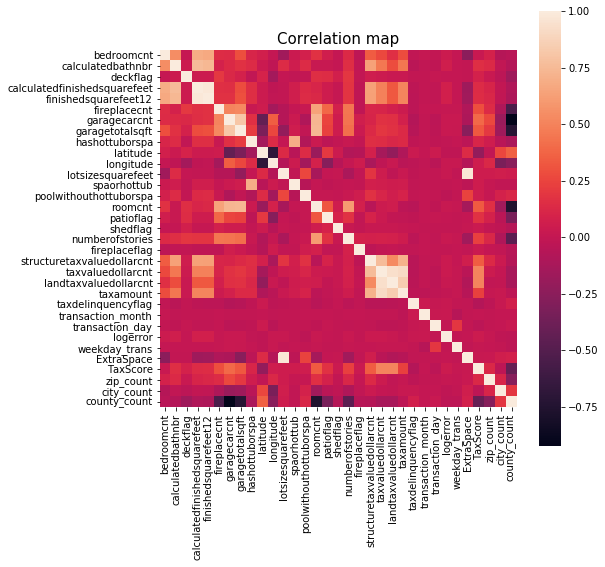

In [102]:
corrmat = df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Correlation map", fontsize=15)
plt.show()

One hot encoding using top5 valuecounts for all 'string' (i.e. categorical features)

In [103]:
# recombine, because otherwise top5 gets screwed up
X_test['logerror'] = y_test.values
df_combo = pd.concat([df, X_test])

print(len(df))
print(len(X_test))
print(len(df_combo))

72220
18055
90275


In [104]:
categorical_features = list(df_combo.select_dtypes('string').columns)

In [105]:
dummy_df = df_combo.copy(deep=True)

for feature in categorical_features:
    top5 = dummy_df[feature].value_counts()[:5].index
    dummy_df[feature] = np.where(~dummy_df[feature].isin(top5), 'Other', dummy_df[feature])

In [106]:
for feature in categorical_features:
    dummy_df = pd.get_dummies(dummy_df, prefix=feature, columns=[feature])

In [107]:
train_cols = [col for col in dummy_df.columns if col not in ['logerror']]

train = dummy_df[train_cols]
test = dummy_df["logerror"]

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.3, random_state=241515)

data_combined = [X_train, X_test]

In [108]:
from sklearn.preprocessing import StandardScaler

scaler_dummy = StandardScaler()
scaler_dummy.fit_transform(X_train)

scaler_dummy.transform(X_test)

array([[-0.02682493, -0.31755033, -0.08609922, ..., -0.7285698 ,
        -0.47074109, -0.44149426],
       [-0.89256612, -0.31755033, -0.08609922, ...,  1.37255209,
        -0.47074109, -0.44149426],
       [-0.02682493, -1.34948647, -0.08609922, ..., -0.7285698 ,
         2.12431001, -0.44149426],
       ...,
       [-0.89256612, -0.31755033, -0.08609922, ..., -0.7285698 ,
         2.12431001, -0.44149426],
       [-0.02682493, -0.31755033, -0.08609922, ...,  1.37255209,
        -0.47074109, -0.44149426],
       [-0.89256612, -0.31755033, -0.08609922, ..., -0.7285698 ,
         2.12431001, -0.44149426]])

Somehow there's still missing values, causing an error for linearregression()

In [109]:
X_train.fillna(0, inplace=True)

In [110]:
X_test.fillna(0, inplace=True)

# Models

In [111]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

#### XGBoost
* Note: XGBoost does not require normalization, but it's normalized anyways

In [112]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
# evaluate predictions
xgb_rmse = sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
print("rmse: " + str(xgb_rmse))
print("mae: " + str(xgb_mae)) 

# rmse: 0.1591731269440407
# mae: 0.06838849935399392

[23:17:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse: 0.1591731269440407
mae: 0.06838849935399392


#### Optimize Hyperparameters

In [113]:
xgb_params = {
    'eta': [0.03, 0.04, 0.05],
    'max_depth': [4,5,6],
    'subsample': [0.80],
    'objective': ['reg:linear'],
    'eval_metric': ['rmse'],
    'lambda': [0.8,0.6,0.4],   
    'alpha': [0.6,0.4,0.2], 
    'silent': [1]
}

#### XGBoost GridSearchCV

In [114]:
from sklearn.model_selection import GridSearchCV
xgb_clf = GridSearchCV(xgb_model,xgb_params, scoring ="neg_mean_squared_error", verbose=1, n_jobs=-1) #"neg_mean_squared_error"
xgb_clf.fit(X_train, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 11.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, r...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.6, 0.4, 0.2], 'eta': [0.03, 0.04, 0.05],
                         'eval_metric': ['rmse'], 'lambda': [0

In [115]:
xgb_clf.best_params_

{'alpha': 0.6,
 'eta': 0.03,
 'eval_metric': 'rmse',
 'lambda': 0.8,
 'max_depth': 4,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.8}

In [116]:
xgb_model = xgb_clf.best_estimator_
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)

# evaluate predictions
xgb_rmse = sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
print("rmse: " + str(xgb_rmse))
print("mae: " + str(xgb_mae)) 

# rmse: 0.159107269798485
# mae: 0.06858397827978056

rmse: 0.159107269798485
mae: 0.06858397827978056


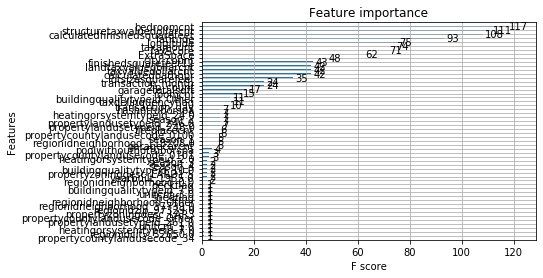

In [117]:
from xgboost import plot_importance

# sorted_idx = np.argsort(xgb_model.feature_importances_)[::-1]

plot_importance(xgb_model)
plt.show()

**Linear Regression**

In [118]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)

linear_reg_rmse = sqrt(mean_squared_error(y_test, y_pred))
linear_reg_mae = mean_absolute_error(y_test, y_pred)
print("rmse: " + str(linear_reg_rmse))
print("mae: " + str(linear_reg_mae)) 

# rmse: 0.1586213719172076
# mae: 0.0682285500533017

rmse: 0.15861525895080592
mae: 0.06822368991094663


#### Ridge Regression
* lets try ridge regresiion

In [119]:
from sklearn.linear_model import Ridge

# lets try a basic model
# Train model with default alpha=1
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

ridge_rmse = sqrt(mean_squared_error(y_test, ridge_pred))
ridge_mae = mean_absolute_error(y_test, ridge_pred)
print("rmse: " + str(ridge_rmse))
print("mae: " + str(ridge_mae)) 

# rmse: 0.15861213319293294
# mae: 0.06822094947116096

rmse: 0.15861214453954076
mae: 0.06822111319873157


#### Ridge Regression GridSearchCV

In [120]:
from sklearn.model_selection import GridSearchCV
alpha = [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 1000, 1500, 2000, 2500, 3000, 5000, 10000]
param_grid = dict(alpha=alpha)

ridge_grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
ridge_grid.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   16.5s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                   10, 100, 1000, 1500, 2000, 2500, 3000, 5000,
                                   10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [121]:
ridge_grid.best_params_
# {'alpha': 10000}

{'alpha': 100}

In [122]:
ridge = ridge_grid.best_estimator_
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

ridge_rmse = sqrt(mean_squared_error(y_test, ridge_pred))
ridge_mae = mean_absolute_error(y_test, ridge_pred)
print("rmse: " + str(ridge_rmse))
print("mae: " + str(ridge_mae)) 

# rmse: 0.158595098857176
# mae: 0.06813961064350516

rmse: 0.15859509836029595
mae: 0.06813961291633801


#### Results
* GridSearchCV told us that the best parameter is the one with a alpha value of 10000
* However, this alpha value leads to overfitting since performance decreased
* We will instead use an alpha value of 10 which led to slight performance improvement

#### Lasso Regression

In [123]:
from sklearn.linear_model import Lasso

# Lets first try a basic model

lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)

lasso_pred = lasso.predict(X_test)

lasso_rmse = sqrt(mean_squared_error(y_test, lasso_pred))
lasso_mae = mean_absolute_error(y_test, lasso_pred)
print("rmse: " + str(lasso_rmse))
print("mae: " + str(lasso_mae)) 

# rmse: 0.15876858368552382
# mae: 0.06800893705070381

rmse: 0.15876858368552382
mae: 0.06800893705070381


#### Lasso Regression GridSearchCV

In [124]:
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
lasso_grid = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
lasso_grid.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   58.8s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Lasso(alpha=1, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [125]:
lasso_grid.best_params_

# {'alpha': 0.001}

{'alpha': 0.1}

In [126]:
lasso = lasso_grid.best_estimator_
lasso.fit(X_train, y_train)

lasso_pred = lasso.predict(X_test)

lasso_rmse = sqrt(mean_squared_error(y_test, lasso_pred))
lasso_mae = mean_absolute_error(y_test, lasso_pred)
print("rmse: " + str(lasso_rmse))
print("mae: " + str(lasso_mae)) 

# rmse: 0.15877555893368261
# mae: 0.06804923262456947

rmse: 0.15877555893368261
mae: 0.06804923262456947


**KNeighborsRegressor**

In [128]:
from sklearn.neighbors import KNeighborsRegressor

# Model creation and fit
kn_regressor = KNeighborsRegressor()
kn_regressor.fit(X_train, y_train)

# Show model results of training set
kn_regressor_pred = kn_regressor.predict(X_test)
kn_rmse = sqrt(mean_squared_error(y_test, kn_regressor_pred))
kn_mae = mean_absolute_error(y_test, kn_regressor_pred)
print("rmse: " + str(kn_rmse))
print("mae: " + str(kn_mae)) 

# rmse: 0.17177681296687541
# mae: 0.08403126758483181

rmse: 0.17177681296687541
mae: 0.08403126758483181


In [129]:
param_grid = {
    'n_neighbors': [3,5,7,15,25],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

In [130]:
kn_grid = GridSearchCV(estimator=kn_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
kn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'n_neighbors': [3, 5, 7, 15, 25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [131]:
kn_grid.best_params_

# {'alpha': 0.001}

{'algorithm': 'ball_tree', 'n_neighbors': 25}

In [132]:
rf_model = kn_grid.best_estimator_
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

rf_rmse = sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)
print("rmse: " + str(rf_rmse))
print("mae: " + str(rf_mae)) 

# rmse: 0.1628133235485317
# mae: 0.0760023788600475

rmse: 0.16099299207499448
mae: 0.0735132898127977


**Neural Network**

In [133]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.layers.noise import GaussianDropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor

x_train = X_train
x_test = X_test

len_x=int(x_train.shape[1])
print("len_x is:",len_x)


# Neural Network
print("\nSetting up neural network model...")
nn = Sequential()
nn.add(Dense(units = 400 , kernel_initializer = 'normal', input_dim = len_x))
nn.add(PReLU())
nn.add(Dropout(.4))
nn.add(Dense(units = 160 , kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(.6))
nn.add(Dense(units = 64 , kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(.5))
nn.add(Dense(units = 26, kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(.6))
nn.add(Dense(1, kernel_initializer='normal'))
nn.compile(loss='mae', optimizer=Adam(lr=4e-3, decay=1e-4))

print("\nFitting neural network model...")
nn.fit(np.array(x_train), np.array(y_train), batch_size = 32, epochs = 70, verbose=2)

print("\nPredicting with neural network model...")
#print("x_test.shape:",x_test.shape)
y_pred_ann = nn.predict(x_test)

nn_rmse = sqrt(mean_squared_error(y_test, y_pred_ann))
nn_mae = mean_absolute_error(y_test, y_pred_ann)
print("rmse: " + str(nn_rmse))
print("mae: " + str(nn_mae)) 

# rmse: 0.1591993789288769
# mae: 0.06779346721974717

Using TensorFlow backend.


len_x is: 108

Setting up neural network model...

Fitting neural network model...
Epoch 1/70
 - 14s - loss: 0.0714
Epoch 2/70
 - 13s - loss: 0.0684
Epoch 3/70
 - 13s - loss: 0.0684
Epoch 4/70
 - 13s - loss: 0.0684
Epoch 5/70
 - 15s - loss: 0.0684
Epoch 6/70
 - 17s - loss: 0.0684
Epoch 7/70
 - 15s - loss: 0.0684
Epoch 8/70
 - 14s - loss: 0.0684
Epoch 9/70
 - 14s - loss: 0.0684
Epoch 10/70
 - 14s - loss: 0.0684
Epoch 11/70
 - 14s - loss: 0.0684
Epoch 12/70
 - 14s - loss: 0.0684
Epoch 13/70
 - 15s - loss: 0.0684
Epoch 14/70
 - 14s - loss: 0.0683
Epoch 15/70
 - 14s - loss: 0.0684
Epoch 16/70
 - 14s - loss: 0.0683
Epoch 17/70
 - 13s - loss: 0.0683
Epoch 18/70
 - 14s - loss: 0.0683
Epoch 19/70
 - 13s - loss: 0.0683
Epoch 20/70
 - 14s - loss: 0.0684
Epoch 21/70
 - 14s - loss: 0.0683
Epoch 22/70
 - 13s - loss: 0.0683
Epoch 23/70
 - 13s - loss: 0.0683
Epoch 24/70
 - 13s - loss: 0.0683
Epoch 25/70
 - 13s - loss: 0.0683
Epoch 26/70
 - 13s - loss: 0.0683
Epoch 27/70
 - 13s - loss: 0.0683
Epoch 28

      Iter       Train Loss   Remaining Time 
         1           0.0682            4.97m
         2           0.0682            4.97m
         3           0.0681            5.11m
         4           0.0681            5.06m
         5           0.0680            5.01m
         6           0.0680            4.98m
         7           0.0680            4.96m
         8           0.0679            4.94m
         9           0.0679            4.92m
        10           0.0679            4.90m
        20           0.0677            4.79m
        30           0.0675            4.71m
        40           0.0675            4.65m
        50           0.0674            4.58m
        60           0.0673            4.51m
        70           0.0673            4.44m
        80           0.0672            4.37m
        90           0.0672            4.30m
       100           0.0671            4.24m
       200           0.0668            3.60m
       300           0.0665            2.99m
       40

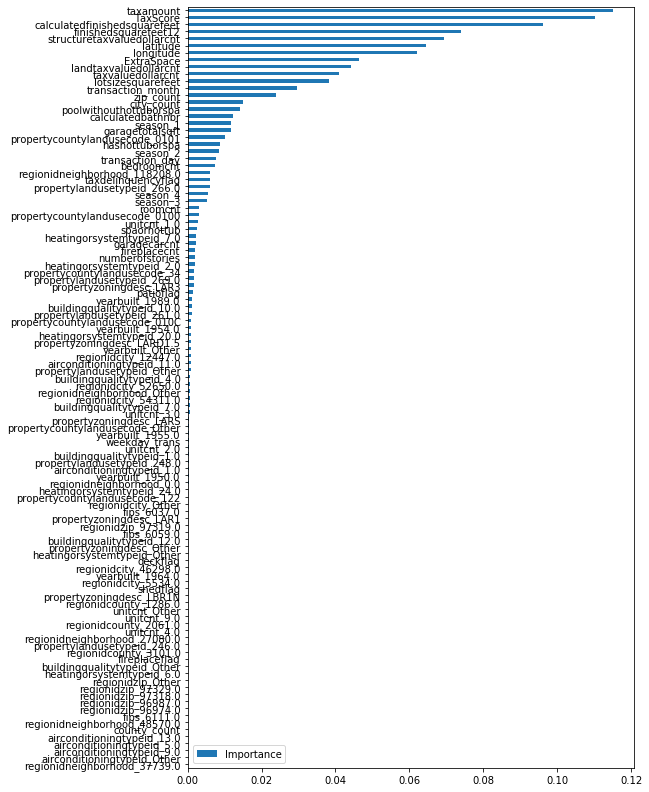

In [134]:
from sklearn.ensemble import  GradientBoostingRegressor

n_estimators=800
gb_regressor = GradientBoostingRegressor(loss='lad',   n_estimators=n_estimators,  verbose=1)
gb_regressor.fit(X_train, y_train)
print('MAE train  {:.4f}'.format(np.mean(np.abs(y_train-gb_regressor.predict(X_train)) )))

#print("x_test.shape:",x_test.shape)
y_pred_gb_regressor = gb_regressor.predict(x_test)

gb_regressor_rmse = sqrt(mean_squared_error(y_test, y_pred_gb_regressor))
gb_regressor_mae = mean_absolute_error(y_test, y_pred_gb_regressor)
print("rmse: " + str(gb_regressor_rmse))
print("mae: " + str(gb_regressor_mae)) 

FeatImp=pd.DataFrame(gb_regressor.feature_importances_, index=X_train.columns, columns=['Importance'])
FeatImp=FeatImp.sort_values('Importance')
FeatImp.plot(kind='barh', figsize=(8,14))
plt.show()

# rmse: 0.1584175607916544
# mae: 0.06693249151086082

In [135]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'max_features': [30, 50, len(X_train.columns)],
    'n_estimators': [600, 700, 800, 850, 900]
}

In [136]:
gb_regressor_grid = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
gb_regressor_grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 46.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 130.6min finished


      Iter       Train Loss   Remaining Time 
         1           0.0682            2.32m
         2           0.0681            2.51m
         3           0.0680            2.57m
         4           0.0680            2.57m
         5           0.0679            2.62m
         6           0.0678            2.62m
         7           0.0678            2.65m
         8           0.0677            2.63m
         9           0.0677            2.60m
        10           0.0677            2.58m
        20           0.0673            2.59m
        30           0.0671            2.52m
        40           0.0669            2.50m
        50           0.0668            2.46m
        60           0.0667            2.42m
        70           0.0665            2.38m
        80           0.0664            2.33m
        90           0.0663            2.29m
       100           0.0662            2.25m
       200           0.0656            1.92m
       300           0.0654            1.61m
       40

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='lad', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=800,
                                                 n_it...one,
                        

In [137]:
gb_regressor_grid.best_params_

# {'alpha': 0.001}

{'max_depth': 5, 'max_features': 30, 'n_estimators': 850}

In [138]:
gb_regressor_model = gb_regressor_grid.best_estimator_
gb_regressor_model.fit(X_train, y_train)

gb_regressor_pred = gb_regressor_model.predict(X_test)

gb_regressor_rmse = sqrt(mean_squared_error(y_test, gb_regressor_pred))
gb_regressor_mae = mean_absolute_error(y_test, gb_regressor_pred)
print("rmse: " + str(gb_regressor_rmse))
print("mae: " + str(gb_regressor_mae)) 

# rmse: 0.1588092296378667
# mae: 0.06717655647518607

      Iter       Train Loss   Remaining Time 
         1           0.0682            2.75m
         2           0.0681            2.72m
         3           0.0680            2.68m
         4           0.0680            2.62m
         5           0.0679            2.66m
         6           0.0678            2.67m
         7           0.0678            2.67m
         8           0.0678            2.63m
         9           0.0677            2.62m
        10           0.0677            2.62m
        20           0.0673            2.62m
        30           0.0671            2.55m
        40           0.0669            2.49m
        50           0.0668            2.47m
        60           0.0667            2.44m
        70           0.0665            2.40m
        80           0.0664            2.34m
        90           0.0663            2.31m
       100           0.0662            2.26m
       200           0.0657            1.92m
       300           0.0653            1.60m
       40

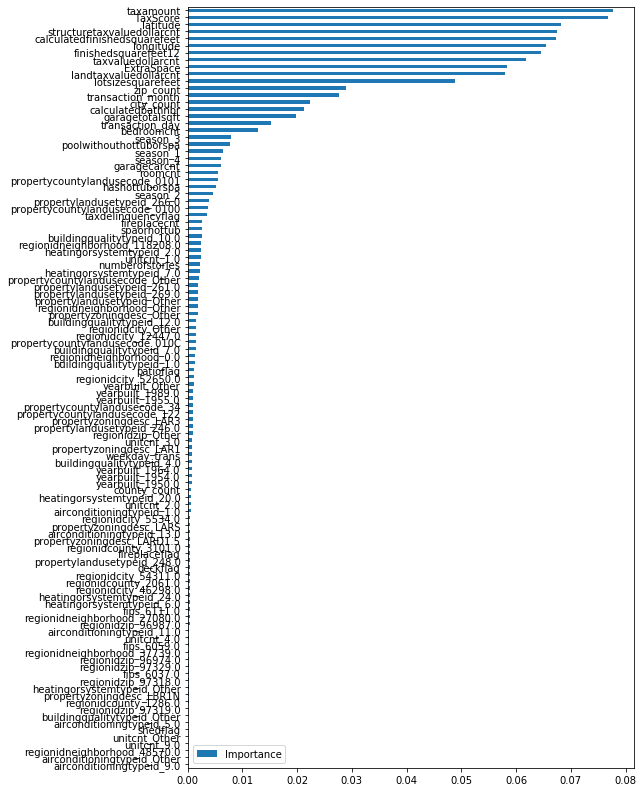

In [139]:
FeatImp=pd.DataFrame(gb_regressor_model.feature_importances_, index=X_train.columns, columns=['Importance'])
FeatImp=FeatImp.sort_values('Importance')
FeatImp.plot(kind='barh', figsize=(8,14))
plt.show()